In [227]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

In [228]:
plt.style.use(['science', 'no-latex'])

In [229]:
# Ghia et al. (1982) - Re = 100
reference_ux_RE_100 = {
    128: 1.00000,
    125: 0.84123,
    124: 0.78871,
    123: 0.73722,
    122: 0.68717,
    109: 0.23151,
    94: 0.00332,
    79: -0.13641,
    64: -0.20581,
    58: -0.21090,
    36: -0.15662,
    22: -0.10150,
    13: -0.06434,
    9: -0.04775,
    8: -0.04192,
    7: -0.03717,
    0: 0.00000
}

# Ghia et al. (1982) - Re = 100
reference_uy_RE_100 = {
    128: 0.00000,
    124: -0.05906,
    123: -0.07391,
    122: -0.08864,
    121: -0.10313,
    116: -0.16914,
    110: -0.22445,
    103: -0.24533,
    64: 0.05454,
    30: 0.17527,
    29: 0.17507,
    20: 0.16077,
    12: 0.12317,
    10: 0.10890,
    9: 0.10091,
    8: 0.09233,
    0: 0.00000
}

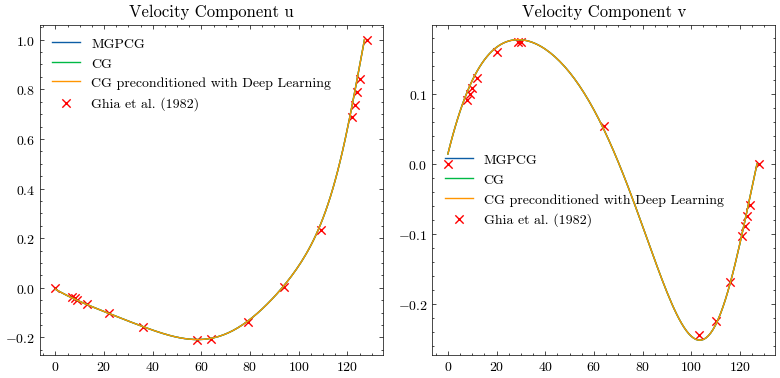

In [244]:
solvers = ["mgpcg", "cg", "dcdm"]
data = {}

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Create a figure with 2 subplots side by side

for solver in solvers:
    u = np.loadtxt(f"experiments_2d/ldc/128/{solver}/u.dat").T
    v = np.loadtxt(f"experiments_2d/ldc/128/{solver}/v.dat").T
    u = u[1:-1, 1:-1]
    v = v[1:-1, 1:-1]
    # Extract the mid-column of u and mid-row of v
    u_mid = u[:, int(u.shape[1]/2)]
    v_mid = v[int(v.shape[0]/2), :]

    solverName = solver.upper()

    if solver == "dcdm":
        solverName = "CG preconditioned with Deep Learning"

    data[solver] = {
        'u_mid': u_mid,
        'v_mid': v_mid
    }

    # Plot u
    axes[0].plot(u_mid, label=solverName)
    axes[1].plot(v_mid, label=solverName)

# Plot reference u value
axes[0].scatter(reference_ux_RE_100.keys(), reference_ux_RE_100.values(), label="Ghia et al. (1982)", color="red", marker="x")
axes[0].set_title("Velocity Component u")
axes[0].legend()

# Plot reference v value
axes[1].scatter(reference_uy_RE_100.keys(), reference_uy_RE_100.values(), label="Ghia et al. (1982)", color="red", marker="x")
axes[1].set_title("Velocity Component v")
axes[1].legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.savefig("ghia_et_al.pdf", format="pdf")
plt.show()

In [231]:
pivot_data_u = {
    'Ghia_u': [],
    'MGPCG_u': [],
    'CG_u': [],
    'DCDM_u': []
}

pivot_data_v = {
    'Ghia_v': [],
    'MGPCG_v': [],
    'CG_v': [],
    'DCDM_v': []
}

for k in reference_ux_RE_100.keys():
    pivot_data_u['Ghia_u'].append(reference_ux_RE_100[k])
    pivot_data_u['MGPCG_u'].append(data['mgpcg']['u_mid'][k] if k < len(data['mgpcg']['u_mid']) else np.nan)
    pivot_data_u['CG_u'].append(data['cg']['u_mid'][k] if k < len(data['cg']['u_mid']) else np.nan)
    pivot_data_u['DCDM_u'].append(data['dcdm']['u_mid'][k] if k < len(data['dcdm']['u_mid']) else np.nan)
    
for k in reference_uy_RE_100.keys():
    pivot_data_v['Ghia_v'].append(reference_uy_RE_100[k])
    pivot_data_v['MGPCG_v'].append(data['mgpcg']['v_mid'][k] if k < len(data['mgpcg']['v_mid']) else np.nan)
    pivot_data_v['CG_v'].append(data['cg']['v_mid'][k] if k < len(data['cg']['v_mid']) else np.nan)
    pivot_data_v['DCDM_v'].append(data['dcdm']['v_mid'][k] if k < len(data['dcdm']['v_mid']) else np.nan)

In [232]:
# Create DataFrame for RMSE calculation
def calculate_rmse(reference_keys, reference, values):
    mask = ~np.isnan(reference) & ~np.isnan(values)
    ref_values = reference[mask]
    val_values = values[mask]
    rmse = np.sqrt(np.mean((ref_values - val_values) ** 2))
    return rmse

In [233]:
df_u = pd.DataFrame(pivot_data_u)
df_v = pd.DataFrame(pivot_data_v)

# Calculate RMSE
rmse_values_u = {
    'Ghia_Ghia_u': 0,  # This is always 0, since we are comparing the same data
    'Ghia_MGPCG_u': calculate_rmse(reference_ux_RE_100.keys(), np.array(list(reference_ux_RE_100.values())), df_u['MGPCG_u'].values),
    'Ghia_CG_u': calculate_rmse(reference_ux_RE_100.keys(), np.array(list(reference_ux_RE_100.values())), df_u['CG_u'].values),
    'Ghia_DCDM_u': calculate_rmse(reference_ux_RE_100.keys(), np.array(list(reference_ux_RE_100.values())), df_u['DCDM_u'].values),
    'MGPCG_Ghia_u': calculate_rmse(reference_ux_RE_100.keys(), df_u['MGPCG_u'].values, np.array(list(reference_ux_RE_100.values()))),
    'MGPCG_MGPCG_u': 0,  # This is always 0, since we are comparing the same data
    'MGPCG_CG_u': calculate_rmse(reference_ux_RE_100.keys(), df_u['MGPCG_u'].values, df_u['CG_u'].values),
    'MGPCG_DCDM_u': calculate_rmse(reference_ux_RE_100.keys(), df_u['MGPCG_u'].values, df_u['DCDM_u'].values),
    'CG_Ghia_u': calculate_rmse(reference_ux_RE_100.keys(), df_u['CG_u'].values, np.array(list(reference_ux_RE_100.values()))),
    'CG_MGPCG_u': calculate_rmse(reference_ux_RE_100.keys(), df_u['CG_u'].values, df_u['MGPCG_u'].values),
    'CG_CG_u': 0,  # This is always 0, since we are comparing the same data
    'CG_DCDM_u': calculate_rmse(reference_ux_RE_100.keys(), df_u['CG_u'].values, df_u['DCDM_u'].values),
    'DCDM_Ghia_u': calculate_rmse(reference_ux_RE_100.keys(), df_u['DCDM_u'].values, np.array(list(reference_ux_RE_100.values()))),
    'DCDM_MGPCG_u': calculate_rmse(reference_ux_RE_100.keys(), df_u['DCDM_u'].values, df_u['MGPCG_u'].values),
    'DCDM_CG_u': calculate_rmse(reference_ux_RE_100.keys(), df_u['DCDM_u'].values, df_u['CG_u'].values),
    'DCDM_DCDM_u': 0  # This is always 0, since we are comparing the same data
}

rmse_values_v = {
    'Ghia_Ghia_v': 0,  # This is always 0, since we are comparing the same data
    'Ghia_MGPCG_v': calculate_rmse(reference_uy_RE_100.keys(), np.array(list(reference_uy_RE_100.values())), df_v['MGPCG_v'].values),
    'Ghia_CG_v': calculate_rmse(reference_uy_RE_100.keys(), np.array(list(reference_uy_RE_100.values())), df_v['CG_v'].values),
    'Ghia_DCDM_v': calculate_rmse(reference_uy_RE_100.keys(), np.array(list(reference_uy_RE_100.values())), df_v['DCDM_v'].values),
    'MGPCG_Ghia_v': calculate_rmse(reference_uy_RE_100.keys(), df_v['MGPCG_v'].values, np.array(list(reference_uy_RE_100.values()))),
    'MGPCG_MGPCG_v': 0,  # This is always 0, since we are comparing the same data
    'MGPCG_CG_v': calculate_rmse(reference_uy_RE_100.keys(), df_v['MGPCG_v'].values, df_v['CG_v'].values),
    'MGPCG_DCDM_v': calculate_rmse(reference_uy_RE_100.keys(), df_v['MGPCG_v'].values, df_v['DCDM_v'].values),
    'CG_Ghia_v': calculate_rmse(reference_uy_RE_100.keys(), df_v['CG_v'].values, np.array(list(reference_uy_RE_100.values()))),
    'CG_MGPCG_v': calculate_rmse(reference_uy_RE_100.keys(), df_v['CG_v'].values, df_v['MGPCG_v'].values),
    'CG_CG_v': 0,  # This is always 0, since we are comparing the same data
    'CG_DCDM_v': calculate_rmse(reference_uy_RE_100.keys(), df_v['CG_v'].values, df_v['DCDM_v'].values),
    'DCDM_Ghia_v': calculate_rmse(reference_uy_RE_100.keys(), df_v['DCDM_v'].values, np.array(list(reference_uy_RE_100.values()))),
    'DCDM_MGPCG_v': calculate_rmse(reference_uy_RE_100.keys(), df_v['DCDM_v'].values, df_v['MGPCG_v'].values),
    'DCDM_CG_v': calculate_rmse(reference_uy_RE_100.keys(), df_v['DCDM_v'].values, df_v['CG_v'].values),
    'DCDM_DCDM_v': 0  # This is always 0, since we are comparing the same data
}

In [234]:
def extract_names(key):
    parts = key.split('_')
    return parts[0], parts[1]

In [239]:
# Initialize dictionaries to hold the DataFrames' data
data_u = {}
data_v = {}

# Populate the data for 'u'
for key, value in rmse_values_u.items():
    col, row = extract_names(key)
    if col not in data_u:
        data_u[col] = {}
    data_u[col][row] = value

# Populate the data for 'v'
for key, value in rmse_values_v.items():
    col, row = extract_names(key)
    if col not in data_v:
        data_v[col] = {}
    data_v[col][row] = value

# Create DataFrames
df_rmse_u = pd.DataFrame(data_u)
df_rmse_v = pd.DataFrame(data_v)

pd.set_option('display.precision', 8)

# Display the DataFrames
print("RMSE DataFrame for 'u':")
print(df_rmse_u.to_latex(float_format="%.8f"))

print("\nRMSE DataFrame for 'v':")
print(df_rmse_v.to_latex(float_format="%.8f"))

RMSE DataFrame for 'u':
\begin{tabular}{lrrrr}
\toprule
 & Ghia & MGPCG & CG & DCDM \\
\midrule
Ghia & 0.00000000 & 0.02740212 & 0.02740183 & 0.02740211 \\
MGPCG & 0.02740212 & 0.00000000 & 0.00000032 & 0.00000004 \\
CG & 0.02740183 & 0.00000032 & 0.00000000 & 0.00000032 \\
DCDM & 0.02740211 & 0.00000004 & 0.00000032 & 0.00000000 \\
\bottomrule
\end{tabular}


RMSE DataFrame for 'v':
\begin{tabular}{lrrrr}
\toprule
 & Ghia & MGPCG & CG & DCDM \\
\midrule
Ghia & 0.00000000 & 0.00818525 & 0.00818521 & 0.00818527 \\
MGPCG & 0.00818525 & 0.00000000 & 0.00000006 & 0.00000007 \\
CG & 0.00818521 & 0.00000006 & 0.00000000 & 0.00000010 \\
DCDM & 0.00818527 & 0.00000007 & 0.00000010 & 0.00000000 \\
\bottomrule
\end{tabular}

